# 1. Introduction

Starting from the end of 2019, COVID-19, an infectious disease caused by a newly discovered coronavirus, has spread over the world and killing almost 200,000 lives up to Apr 24th, 2020. It is confirmed COVID-19 can mainly be transmitted over droplet and airborne. It can be transmitted even faster among crowded spaces like some specific places or venues. This is why when the virus outbreak becomes severe, restaurants, clubs, gyms, etc are forced to shut down to enforce the social distance. This study is an exploratory analysis of how the severity of COVID-19 outbreak is related to the neighborhood with various venues. More specifically this study focuses on New York City.

This study can provide a straightforward view to the public, business owners and policymakers on the relation between COVID-19 breakout and characteristics of venues. It may help the public to avoid some neighborhoods or venues with a high risk of exposure to the virus. The policymakers can understand how to restrict and ease the business to minimize the spread of the virus. Business owners can evaluate their business's future as well.

# 2. Data

This study mainly focuses on New York City. The reason is that NYC is the most harshly impacted by the virus meanwhile it is one of the most modern cities with the complete city systems and variety of the venues. Besides, New York City provides the data on boroughs level. 

To explore the relation between neighborhood with various venues and the number of confirmed, we will cluster the neighborhood based on the compositions of the venues. And then, we will visualize the clustered labels on the heated map of confirmed cases on NYC map. To reach the goal, we need data on geoinformation of the neighborhoods in NYC, venues in all neighborhoods, boundaries of boroughs in NYC, and the number of cases in NYC.

The data will be collected from four sources. The venues data is collected through the Foursquare API, which shows all searchable venues and their types in all neighborhoods . The geo info of all neighborhoods in NYC is from IBM Cognitive Lab, like latitudes and longitudes of some neighborhood. The borough boundaries in NYC data is from dwillis on Github, which helps with map visualization. And at last, the confirmed cases by boroughs in NYC is from the NYC government website. We only use the number of the confirmed till April 22th, 2020.

This is data of confirmed cases in NYC, other data will be preprocessed in the data processing section in the next week.

# 3. Data Wrangling

Import all the libraries used in this notebook

In [2]:
!pip install folium

In [26]:
!pip install yellowbrick

     |████████████████████████████████| 266kB 21.9MB/s eta 0:00:01


In [27]:
import pandas as pd
import numpy as np
import folium
import json
from pandas.io.json import json_normalize
import requests
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Kmeans elbow visualization
from yellowbrick.cluster import KElbowVisualizer


## 3.1 Clean data of Confirmed cases.

In [5]:
# The code was removed by Watson Studio for sharing.

Borough  Confirmed_per_100k  Confirmed
0          Bronx             2168.35      31911
1       Brooklyn             1384.30      37564
2      Manhattan              943.61      17803
3         Queens             1748.42      43824
4  Staten Island             2109.68      10582

## 3.2 Import the Boundaries of NYC and Visualize the Choropleth

Get the boundaries data from the following link

In [6]:
!wget "https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson" -O nyc.json
nyc_geo = r'nyc.json'

--2020-04-25 02:01:26--  https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3077124 (2.9M) [text/plain]
Saving to: ‘nyc.json’

100%[======================================>] 3,077,124   --.-K/s   in 0.09s   

2020-04-25 02:01:27 (30.9 MB/s) - ‘nyc.json’ saved [3077124/3077124]



Visualize the choropleth based on the number confirmed cases

In [7]:
nyc_map = folium.Map(location = [40.7128, -74], zoom_start = 11)

nyc_map.choropleth(
    geo_data = nyc_geo,
    data = df_cov_nycity,
    columns = ['Borough', 'Confirmed'],
    key_on = 'feature.properties.BoroName',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity=0.4,
    legend_name='Confirmed Cases'
    )

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [8]:
nyc_map

## 3.3 Cleaning neighbohoods and venues data

Import the neighborhood data from IBM cognitive lab.

In [9]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Generate dataframe from neighborhood data

In [10]:
neighborhoods_data = newyork_data['features']
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [11]:
nyc_nei = neighborhoods.copy()
nyc_nei.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

Import the venues data from Foursquare API

In [12]:
CLIENT_ID = 'WUO0KU5TLNYJRJNUA3ZF0ZXG5PV0VPPRNRVGIAZTOHMW0SKO' # your Foursquare ID
CLIENT_SECRET = '3ET1SKVGIJAOB0IR2YWQRY1HRR3EKPDH2SJEUBDQCZW12QXK' # your Foursquare Secret
VERSION = '20200421'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WUO0KU5TLNYJRJNUA3ZF0ZXG5PV0VPPRNRVGIAZTOHMW0SKO
CLIENT_SECRET:3ET1SKVGIJAOB0IR2YWQRY1HRR3EKPDH2SJEUBDQCZW12QXK


In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Define the function of obtaining venue data from Foursquare and transforming it into a dataframe.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        for tries in range(5):
            try:    
                # make the GET request
                results = requests.get(url).json()["response"]['groups'][0]['items']
            except:
                if tries < 4:
                    print("failed times:", tries + 1)
                    continue
                else:
                    print(name, " is wrong.")
            break
            # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
failed times: 1
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Bo

Take a look at the shape and first 5 rows of the nyc_venues dataframe

In [17]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
print('There are {} neighborhoods.'.format(len(nyc_venues['Neighborhood'].unique())))

nyc_venues.head()

There are 384 uniques categories.
There are 301 neighborhoods.


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

To cluster the neighbohood, we need to transfer the categorical variables to dummy variables.

In [18]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.rename(columns = {'Neighborhood':'Neighborhood_cat'}, inplace = True)
nyc_onehot = nyc_venues[['Neighborhood']].join(nyc_onehot)
nyc_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    Wakefield                  0               0                  0   
1    Wakefield                  0               0                  0   
2    Wakefield                  0               0                  0   
3    Wakefield                  0               0                  0   
4    Wakefield                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   

   Arcade  Arepa Restaurant  ...  Warehouse Store  Waste Facility  Waterfront  \
0       0                 0  ...                0               0           0   
1       0                 0  ...                0               0           0   
2       0                 0  ...                0               0           0   
3       0                 0  ...                0               0           0   
4       0                 0  ...                0               0           0   

   Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0                   0           0         0          0            0   
1                   0           0         0          0            0   
2                   0           0         0          0            0   
3                   0           0         0          0            0   
4                   0           0         0          0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 385 columns]

Aggregate the data by neighborhoods.

In [52]:
nyc_grouped_sum = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped_sum.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0       Allerton                0.0             0.0                0.0   
1       Annadale                0.0             0.0                0.0   
2  Arden Heights                0.0             0.0                0.0   
3      Arlington                0.0             0.0                0.0   
4       Arrochar                0.0             0.0                0.0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                 0.0               0.0             0.000000           0.0   
1                 0.0               0.0             0.000000           0.0   
2                 0.0               0.0             0.000000           0.0   
3                 0.0               0.0             0.166667           0.0   
4                 0.0               0.0             0.000000           0.0   

   Arcade  Arepa Restaurant  ...  Warehouse Store  Waste Facility  Waterfront  \
0     0.0               0.0  ...              0.0             0.0         0.0   
1     0.0               0.0  ...              0.0             0.0         0.0   
2     0.0               0.0  ...              0.0             0.0         0.0   
3     0.0               0.0  ...              0.0             0.0         0.0   
4     0.0               0.0  ...              0.0             0.0         0.0   

   Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0                 0.0         0.0       0.0        0.0          0.0   
1                 0.0         0.0       0.0        0.0          0.0   
2                 0.0         0.0       0.0        0.0          0.0   
3                 0.0         0.0       0.0        0.0          0.0   
4                 0.0         0.0       0.0        0.0          0.0   

   Women's Store  Yoga Studio  
0            0.0          0.0  
1            0.0          0.0  
2            0.0          0.0  
3            0.0          0.0  
4            0.0          0.0  

[5 rows x 385 columns]

To generate datafram of the first 5 venues categories in neighborhoods

In [53]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped_sum.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place         Deli / Bodega   
1       Annadale          Dance Studio            Sports Bar   
2  Arden Heights         Deli / Bodega              Bus Stop   
3      Arlington              Bus Stop         Deli / Bodega   
4       Arrochar         Deli / Bodega              Bus Stop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0        Cosmetics Shop           Supermarket      Department Store  
1         Train Station           Pizza Place            Restaurant  
2              Pharmacy           Coffee Shop           Pizza Place  
3          Intersection   American Restaurant         Grocery Store  
4    Italian Restaurant    Athletics & Sports            Nail Salon

# 4. Cluster the neighborhoods by venues catagories.

In [55]:
model = KMeans(random_state = 1010)
nyc_grouped_clustering = nyc_grouped_sum.drop('Neighborhood', 1)

Pick up the best k by elbow method

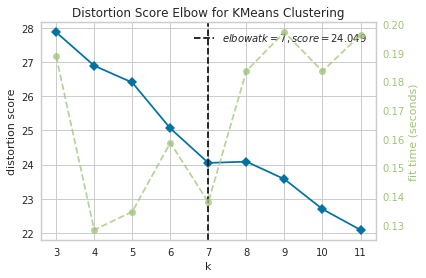

In [56]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(model, k=(3,12), timing = False)

visualizer.fit(nyc_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Choose the best clusters number and run kmeans clustering

In [58]:
# set number of clusters
kclusters = 7


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 6, 5, 5, 5, 6, 0, 6, 0, 6], dtype=int32)

Attach the cluster labesl to venues sorted dataframe.

In [60]:
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except: 
    neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
neighborhoods_venues_sorted.head()

Cluster Labels   Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0               6       Allerton           Pizza Place         Deli / Bodega   
1               6       Annadale          Dance Studio            Sports Bar   
2               5  Arden Heights         Deli / Bodega              Bus Stop   
3               5      Arlington              Bus Stop         Deli / Bodega   
4               5       Arrochar         Deli / Bodega              Bus Stop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0        Cosmetics Shop           Supermarket      Department Store  
1         Train Station           Pizza Place            Restaurant  
2              Pharmacy           Coffee Shop           Pizza Place  
3          Intersection   American Restaurant         Grocery Store  
4    Italian Restaurant    Athletics & Sports            Nail Salon

In [62]:
# add clustering labels

nyc_merged = nyc_nei

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), how = 'right', on='Neighborhood')
# nyc_merged.astype({'Cluster Labels': 'int32'})
nyc_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201               6   
1   Bronx   Co-op City  40.874294 -73.829939               6   
2   Bronx  Eastchester  40.887556 -73.827806               6   
3   Bronx    Fieldston  40.895437 -73.905643               6   
4   Bronx    Riverdale  40.890834 -73.912585               6   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy          Dessert Shop        Ice Cream Shop   
1           Bus Station            Restaurant        Baseball Field   
2  Caribbean Restaurant                 Diner         Deli / Bodega   
3           Bus Station                 River                 Plaza   
4           Bus Station                  Park            Food Truck   

  4th Most Common Venue       5th Most Common Venue  
0           Gas Station                  Donut Shop  
1    Salon / Barbershop        Fast Food Restaurant  
2     Convenience Store                 Bus Station  
3           Yoga Studio  Financial or Legal Service  
4        Baseball Field                         Gym

Add clustered neighborhood markers on choropleth map of the confirmed cases per 100k of COVID-19

In [64]:
# choropleth layer

nyc_map = folium.Map(location = [40.7128, -74], zoom_start = 11)

nyc_map.choropleth(
    geo_data = nyc_geo,
    data = df_cov_nycity,
    columns = ['Borough', 'Confirmed_per_100k'],
    key_on = 'feature.properties.BoroName',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity=0.4,
    legend_name='Confirmed_per_100k'
    )

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=False,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.3,
    legend_name='Type ' + str(cluster)).add_to(nyc_map)
       
nyc_map

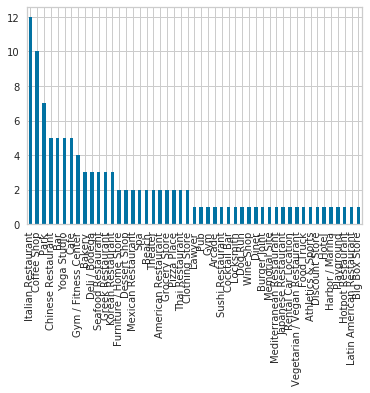

In [83]:
nyc_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[list(range(5, 6))]]
nyc_0['1st Most Common Venue'].value_counts().plot(kind = 'bar')

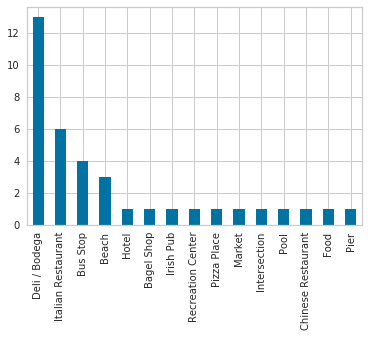

In [84]:
nyc_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[list(range(5, 6))]]
nyc_5['1st Most Common Venue'].value_counts().plot(kind = 'bar')

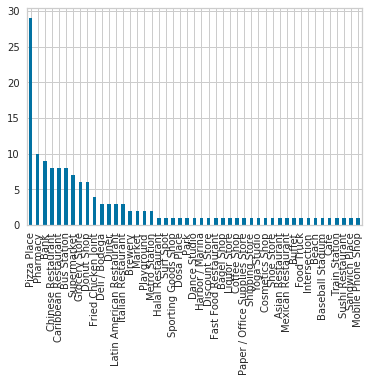

In [85]:
nyc_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[list(range(5, 6))]]
nyc_5['1st Most Common Venue'].value_counts().plot(kind = 'bar')